In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
!pip install tensorflow_text
import tensorflow_text

In [ ]:
import pandas as pd
import csv
import numpy as np
import re
from tensorflow.keras import models,layers
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model

In [ ]:
df_train=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DATASETS/ADL_PROJECT1/snli_1.0/snli_1.0_train.txt",sep="\t",na_filter=False,usecols=["gold_label","sentence1","sentence2"])

In [ ]:
df_val=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DATASETS/ADL_PROJECT1/snli_1.0/snli_1.0_dev.txt",sep="\t",na_filter=False,usecols=["gold_label","sentence1","sentence2"])

In [ ]:
df_test=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DATASETS/ADL_PROJECT1/snli_1.0/snli_1.0_test.txt",sep="\t",na_filter=False,usecols=["gold_label","sentence1","sentence2"])

In [ ]:
df_train.head()

,gold_label,sentence1,sentence2
0,neutral,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.
1,contradiction,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette."
2,entailment,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse."
3,neutral,Children smiling and waving at camera,They are smiling at their parents
4,entailment,Children smiling and waving at camera,There are children present


In [ ]:
df_train=df_train[df_train['gold_label']!='-']
df_val=df_val[df_val['gold_label']!='-']
df_test=df_test[df_test['gold_label']!='-']

In [ ]:
df_val.gold_label.unique()

array(['neutral', 'entailment', 'contradiction'], dtype=object)

In [ ]:
labels={'neutral':0, 'entailment':1, 'contradiction':0}

In [ ]:
df_train["labels"]=df_train["gold_label"].map(labels)
df_val["labels"]=df_val["gold_label"].map(labels)
df_test["labels"]=df_test["gold_label"].map(labels)

In [ ]:
df_val.head()

,gold_label,sentence1,sentence2,labels
0,neutral,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...,0
1,entailment,Two women are embracing while holding to go pa...,Two woman are holding packages.,1
2,contradiction,Two women are embracing while holding to go pa...,The men are fighting outside a deli.,0
3,entailment,"Two young children in blue jerseys, one with t...",Two kids in numbered jerseys wash their hands.,1
4,neutral,"Two young children in blue jerseys, one with t...",Two kids at a ballgame wash their hands.,0


In [ ]:
## Putting space b/w Special Characters
def is_special(text):
    rem = ''
    for i in text: 
        if i.isalnum():
            rem = rem + i
        else:
            rem = rem + ' '
            rem=rem+i
            rem = rem + ' '
    return rem

In [ ]:
## removing extra spsces from text
def rem_extra(text):
    rem=re.sub(' +', ' ',text)
    return str(rem).strip()

In [ ]:
def lower1(text):
    return text.lower()

In [ ]:
df_test.sentence1=df_test.sentence1.apply(is_special)
df_test.sentence2=df_test.sentence2.apply(is_special)

In [ ]:
df_test.sentence1=df_test.sentence1.apply(lower1)
df_test.sentence2=df_test.sentence2.apply(lower1)

In [ ]:
df_test.sentence1=df_test.sentence1.apply(rem_extra)
df_test.sentence2=df_test.sentence2.apply(rem_extra)

In [ ]:
df_train.sentence1=df_train.sentence1.apply(is_special)
df_train.sentence2=df_train.sentence2.apply(is_special)

In [ ]:
df_train.sentence1=df_train.sentence1.apply(lower1)
df_train.sentence2=df_train.sentence2.apply(lower1)

In [ ]:
df_train.sentence1=df_train.sentence1.apply(rem_extra)
df_train.sentence2=df_train.sentence2.apply(rem_extra)

In [ ]:
df_val.sentence1=df_val.sentence1.apply(is_special)
df_val.sentence2=df_val.sentence2.apply(is_special)

In [ ]:
df_val.sentence1=df_val.sentence1.apply(lower1)
df_val.sentence2=df_val.sentence2.apply(lower1)

In [ ]:
df_val.sentence1=df_val.sentence1.apply(rem_extra)
df_val.sentence2=df_val.sentence2.apply(rem_extra)

In [ ]:
df_train.head()

,gold_label,sentence1,sentence2,labels
0,neutral,a person on a horse jumps over a broken down a...,a person is training his horse for a competiti...,0
1,contradiction,a person on a horse jumps over a broken down a...,"a person is at a diner , ordering an omelette .",0
2,entailment,a person on a horse jumps over a broken down a...,"a person is outdoors , on a horse .",1
3,neutral,children smiling and waving at camera,they are smiling at their parents,0
4,entailment,children smiling and waving at camera,there are children present,1


In [ ]:
# df_train.sentence1=df_train.sentence1.apply(tf.constant)
# df_train.sentence2=df_train.sentence2.apply(tf.constant)

In [ ]:
# df_val.sentence1=df_val.sentence1.apply(tf.constant)
# df_val.sentence2=df_val.sentence2.apply(tf.constant)

In [ ]:
# df_test.sentence1=df_test.sentence1.apply(tf.constant)
# df_test.sentence2=df_test.sentence2.apply(tf.constant)

In [ ]:
df_train.head()

,gold_label,sentence1,sentence2,labels
0,neutral,a person on a horse jumps over a broken down a...,a person is training his horse for a competiti...,0
1,contradiction,a person on a horse jumps over a broken down a...,"a person is at a diner , ordering an omelette .",0
2,entailment,a person on a horse jumps over a broken down a...,"a person is outdoors , on a horse .",1
3,neutral,children smiling and waving at camera,they are smiling at their parents,0
4,entailment,children smiling and waving at camera,there are children present,1


# Load BERT and BERT text preprocessor

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
    trainable=False)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
#sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].

# Build Classifier

In [ ]:
tf.keras.backend.clear_session()
inp1=tf.keras.layers.Input(shape=(), dtype=tf.string)
inp2=tf.keras.layers.Input(shape=(), dtype=tf.string)
embedding_model1 = tf.keras.Model(text_input, pooled_output)
embedding_model2 = tf.keras.Model(text_input, pooled_output)
x1=embedding_model1(inp1)
x2=embedding_model2(inp2)
x=tf.keras.layers.concatenate((x1,x2))
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dense(1)(x)
model=tf.keras.Model([inp1,inp2],x)


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [ ]:
 model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 768)          109482241   input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 768)          109482241   input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.fit([df_val.sentence1,df_val.sentence2],df_val.labels.values,epochs=3)

Epoch 1/3
 27/308 [=>............................] - ETA: 5:45 - loss: 1.3010 - accuracy: 0.5775

KeyboardInterrupt: ignored

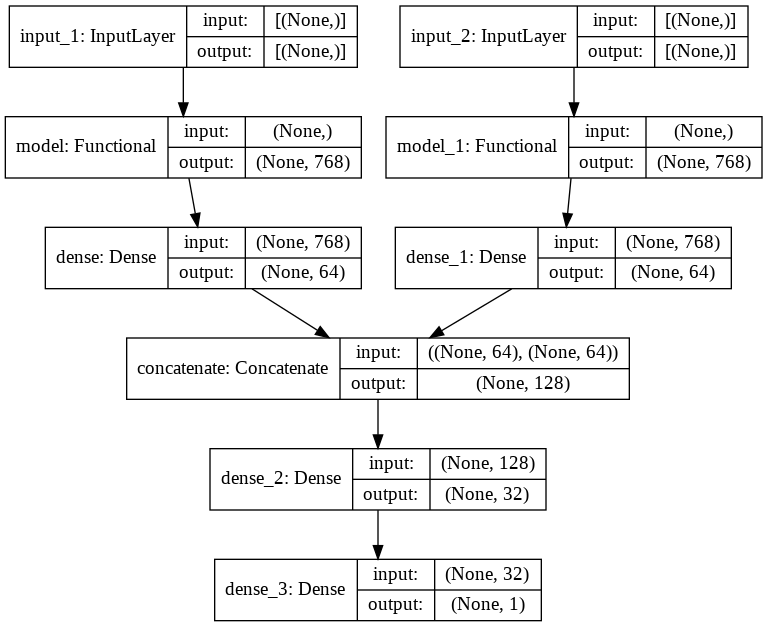

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,expand_nested=False)